# Assignment 2 (Part b) : SVMs
# Qeustion 1 : Binary Classification 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from time import time
import math
from cvxopt import solvers, matrix

from scipy.spatial.distance import cdist

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from itertools import combinations 

from joblib import Parallel, delayed
import multiprocessing

In [2]:
def getData(train, test, val, class1=2, class2=3):
    train = train[np.logical_or(train[:,-1]==class1, train[:,-1]==class2)] 
    val = val[np.logical_or(val[:,-1]==class1, val[:,-1]==class2)] 
    test = test[np.logical_or(test[:,-1]==class1, test[:,-1]==class2)] 

    X_train = train[:,:-1]/255
    Y_train = train[:,-1]
    Y_train = np.array([-1 if i==class1 else 1 for i in Y_train], dtype=int).reshape((Y_train.shape[0],1))

    X_val = val[:,:-1]/255
    Y_val = val[:,-1]
    Y_val = np.array([-1 if i==class1 else 1 for i in Y_val], dtype=int).reshape((Y_val.shape[0],1))

    X_test = test[:,:-1]/255
    Y_test = test[:,-1]
    Y_test = np.array([-1 if i==class1 else 1 for i in Y_test], dtype=int).reshape((Y_test.shape[0],1))
    
    return (X_train, Y_train, X_val, Y_val, X_test, Y_test)

train = pd.read_csv('./data/train.csv', header=None).to_numpy()
val = pd.read_csv('./data/val.csv', header=None).to_numpy()
test = pd.read_csv('./data/test.csv', header=None).to_numpy()

(X_train, Y_train, X_val, Y_val, X_test, Y_test) = getData(train, test, val, class1=2, class2=3)

X_train_whole = train[:,:-1]/255
Y_train_whole = train[:,-1].ravel()
Y_train_whole = Y_train_whole.astype(int)

X_val_whole = val[:,:-1]/255
Y_val_whole = val[:,-1].ravel()
Y_val_whole = Y_val_whole.astype(int)

X_test_whole = test[:,:-1]/255
Y_test_whole = test[:,-1].ravel()
Y_test_whole = Y_test_whole.astype(int)

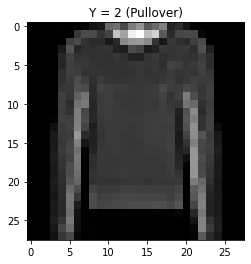

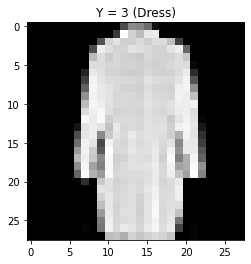

In [3]:
plt.imshow(X_train[np.where(Y_train.ravel() == -1)][0].reshape((28,28)), cmap='gray')
plt.title('Y = 2 (Pullover)')
plt.show()
plt.imshow(X_train[np.where(Y_train.ravel() == 1)][0].reshape((28,28)), cmap='gray')
plt.title('Y = 3 (Dress)')
plt.show()

## Part (a) : Implementing Linear SVM

In [4]:
class SVM:
    '''
    This class provides implementation of SVM.
    
    **************
    Parameters:
    C : Regularization parameter (Defalts 1.0)
    threshold : Threshold for alphas i.e. alpha values below this will be treated as 0 (Defalts 1e-5)
    kernel : Type of kernel you want to use ('linear' or 'rbf')
    gamma : Hyperparameter for rbf kernel
    showTime : Boolean to show time taken to fit
    **************
    '''
    __slots__=['C', 'threshold', 'kernel', 'gamma', 'showTime', 'silentCVXOPT', 'alphas', 'nSV', 'SV_indices', 'SV_y', 'SV', 'w', 'b']

    def __init__(self, C=1, threshold=1e-5, kernel='linear', gamma=0.05, showTime=True, silentCVXOPT = False):
        self.C = C
        self.threshold = threshold
        self.kernel = kernel
        self.gamma = gamma
        self.showTime = showTime
        self.silentCVXOPT = silentCVXOPT
    
    def _getRBFKernelMat(self, X, gamma = 0.05):
        return np.exp(-gamma*(cdist(X,X,'euclidean')**2))
    
    def fit(self, X_train, Y_train):
        t0 = time()
        
        if self.kernel=='linear':
            P = Y_train.dot(Y_train.T) * (X_train.dot(X_train.T))
        elif self.kernel=='rbf':
            K = self._getRBFKernelMat(X_train, self.gamma)
            P = Y_train.dot(Y_train.T) * (K)
        P=matrix(P,tc='d')

        q = -np.ones(X_train.shape[0])
        q=matrix(q,tc='d')

        G = np.vstack((-np.identity(X_train.shape[0]), np.identity(X_train.shape[0])))
        G=matrix(G,tc='d')

        h = np.hstack((np.zeros(X_train.shape[0]), np.zeros(X_train.shape[0])+self.C))
        h=matrix(h,tc='d')

        A = Y_train.T
        A = matrix(A,tc='d')
        b=matrix([0],tc='d')
        if self.silentCVXOPT:
            solvers.options['show_progress'] = False
        opt = solvers.qp(P, q, G, h, A, b)

        self.alphas = np.array(opt['x']).ravel()

        self.alphas[self.alphas<self.threshold] = 0

        self.nSV = np.where(self.alphas > 0)[0].shape[0]
        self.SV_indices = np.where(self.alphas > 0)[0]
        self.SV_y = Y_train[self.SV_indices].ravel()
        self.SV = X_train[self.SV_indices]
        
        if self.kernel == 'linear':
            self.w = (X_train[self.SV_indices]).T.dot((Y_train[self.SV_indices].ravel())*self.alphas[self.SV_indices])
            X_pos = X_train[np.where(Y_train.ravel() == 1)]
            X_neg = X_train[np.where(Y_train.ravel() == -1)]
            self.b = -(1/2)*(min(X_pos.dot(self.w)) + max(X_neg.dot(self.w)))

        elif self.kernel == 'rbf':
            X_pos_indices = np.where(Y_train.ravel() == 1)[0]
            X_neg_indices = np.where(Y_train.ravel() == -1)[0]
            alphaiXyi = self.alphas*Y_train.ravel()
            Min = math.inf
            for i in X_pos_indices:            
                Sum = 0
                for j in self.SV_indices:
                    Sum = Sum + (alphaiXyi[j] * K[i,j])
                if(Sum<Min):
                    Min=Sum
            Max = -math.inf
            for i in X_neg_indices:
                Sum = 0
                for j in self.SV_indices:
                    Sum = Sum + (alphaiXyi[j] * K[i,j])
                if(Sum>Max):
                    Max=Sum
            self.b = -(1/2)*(Max+Min)
        if self.showTime:
            print("Training completed in %.2f seconds"%((time()-t0)))
        

    def predict(self,X):
        pred = list()
        if self.kernel=='linear':
            for pt in X:
                if (self.SV).T.dot(self.SV_y*self.alphas[self.SV_indices]).dot(pt) + self.b > 0:
                    pred.append(1)
                else:
                    pred.append(-1)
        elif self.kernel=='rbf':
            wTxB = (np.exp(-0.05*cdist(self.SV, X)**2).T)@(self.alphas[self.SV_indices]*self.SV_y).reshape((-1,1)) + self.b
            wTxB[wTxB > 0] = 1
            wTxB[wTxB < 0] = -1
            pred = wTxB
        return np.array(pred, dtype='int32')
    
    def decision_function(self, X):
        score = list()
        if self.kernel=='linear':
            for pt in X:
                score.append((self.SV).T.dot(self.SV_y*self.alphas[self.SV_indices]).dot(pt) + self.b)
        elif self.kernel=='rbf':
            score = (np.exp(-0.05*cdist(self.SV, X)**2).T)@(self.alphas[self.SV_indices]*self.SV_y).reshape((-1,1)) + self.b
        return np.array(score)
        
#     def get_alphas(self):
#         return self.alphas
#     def get_nSV(self):
#         return self.nSV
#     def get_SV_indices(self):
#         return self.SV_indices
#     def get_SV_y(self):
#         return self.SV_y
#     def get_SV(self):
#         return self.SV
#     def get_w(self):
#         return self.w
#     def get_b(self):
#         return self.b

class metrics:
    
    def accuracy_score(y_true, y_pred):
        true = sum(y_true.ravel() == y_pred.ravel())
        return true*100/len(y_true)
    
    def confusion_matrix(y_true, y_pred, title = 'Confusion Matrix'):
        classes = np.unique(y_true)
        n_classes=len(classes)
        cm=pd.DataFrame(np.zeros((n_classes,n_classes), dtype=int), index=classes, columns=classes)
        
        for i in range(len(y_true)):
            cm[y_pred[i],y_true[i]]+=1
        
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt="d", cbar=False, linecolor='black',linewidth='0', \
        cmap='blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(title)
        plt.show()

In [5]:
linearSVM = SVM(C=1.0, threshold=1e-5, kernel='linear')

linearSVM.fit(X_train, Y_train)

     pcost       dcost       gap    pres   dres
 0: -5.2396e+02 -9.3983e+03  5e+04  3e+00  3e-12
 1: -3.3568e+02 -5.4793e+03  1e+04  5e-01  3e-12
 2: -2.0714e+02 -1.8273e+03  3e+03  1e-01  2e-12
 3: -1.4999e+02 -9.1602e+02  1e+03  5e-02  2e-12
 4: -1.1131e+02 -4.9405e+02  6e+02  2e-02  1e-12
 5: -9.0544e+01 -3.1115e+02  3e+02  8e-03  1e-12
 6: -8.5666e+01 -1.4689e+02  7e+01  6e-04  1e-12
 7: -9.2854e+01 -1.1845e+02  3e+01  2e-16  1e-12
 8: -9.8193e+01 -1.0801e+02  1e+01  6e-15  1e-12
 9: -1.0058e+02 -1.0337e+02  3e+00  8e-15  1e-12
10: -1.0167e+02 -1.0194e+02  3e-01  3e-15  1e-12
11: -1.0178e+02 -1.0179e+02  5e-03  2e-15  1e-12
12: -1.0179e+02 -1.0179e+02  9e-05  1e-14  1e-12
Optimal solution found.
Training completed in 67.98 seconds


In [6]:
print('Number of support vectors :',linearSVM.nSV)

Number of support vectors : 370


In [7]:
pred_train = linearSVM.predict(X_train)
accuracy_train = metrics.accuracy_score(Y_train, pred_train)

pred_test = linearSVM.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, pred_test)

pred_val = linearSVM.predict(X_val)
accuracy_val = metrics.accuracy_score(Y_val, pred_val)

print('Accuracy on Train Dataset : ', accuracy_train)
print('Accuracy on Validation Dataset : ', accuracy_val)
print('Accuracy on Test Dataset : ', accuracy_test)

Accuracy on Train Dataset :  92.77777777777777
Accuracy on Validation Dataset :  89.6
Accuracy on Test Dataset :  91.3


## Part B : Applying SVM with Gaussian Kernel

In [9]:
rbfSVM = SVM(C=1.0, threshold=1e-5, kernel='rbf', gamma=0.05)

rbfSVM.fit(X_train, Y_train)

     pcost       dcost       gap    pres   dres
 0: -3.0404e+02 -8.2833e+03  4e+04  2e+00  1e-15
 1: -2.1981e+02 -4.4663e+03  7e+03  3e-01  2e-15
 2: -1.8274e+02 -1.0106e+03  1e+03  3e-02  2e-15
 3: -2.3561e+02 -4.7608e+02  3e+02  6e-03  2e-15
 4: -2.6244e+02 -3.3488e+02  8e+01  1e-03  2e-15
 5: -2.7389e+02 -2.9769e+02  2e+01  2e-04  2e-15
 6: -2.7877e+02 -2.8539e+02  7e+00  4e-05  2e-15
 7: -2.8041e+02 -2.8192e+02  2e+00  3e-06  2e-15
 8: -2.8091e+02 -2.8102e+02  1e-01  7e-08  2e-15
 9: -2.8095e+02 -2.8095e+02  2e-03  9e-10  2e-15
10: -2.8095e+02 -2.8095e+02  4e-05  1e-11  2e-15
Optimal solution found.
Training completed in 67.55 seconds


In [10]:
rbfSVM.b

-0.5344522525496851

In [11]:
print('Number of support vectors in RBF-SVM:',rbfSVM.nSV)

Number of support vectors in RBF-SVM: 1123


In [12]:
pred_train = rbfSVM.predict(X_train)
accuracy_train = metrics.accuracy_score(Y_train, pred_train)

pred_test = rbfSVM.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, pred_test)

pred_val = rbfSVM.predict(X_val)
accuracy_val = metrics.accuracy_score(Y_val, pred_val)

print('Accuracy on Train Dataset :', accuracy_train)
print('Accuracy on Validation Dataset :', accuracy_val)
print('Accuracy on Test Dataset :', accuracy_test)

Accuracy on Train Dataset : 99.4
Accuracy on Validation Dataset : 97.2
Accuracy on Test Dataset : 96.1


## Part c : Comparing our implementation with scikit-learn's implementation

In [5]:
svm = SVC(C=1, kernel='linear')
t0 = time()
svm.fit(X_train, Y_train.ravel())
print('Linear SVM trined in %.2f sec'%(time()-t0))

# print('W : %s'%(svm.coef_))
# print('b : %s'%(svm.intercept_))
print('nSV : %s'%(svm.n_support_))
print('Total Support vectors : %s'%(svm.n_support_.sum()))

pred_train = svm.predict(X_train)
pred_val = svm.predict(X_val)
pred_test = svm.predict(X_test)

print('Accuracy on train data %.2f %c'%(accuracy_score(Y_train, pred_train)*100,'%'))
print('Accuracy on validation data %.2f %c'%(accuracy_score(Y_val, pred_val)*100,'%'))
print('Accuracy on test data %.2f %c'%(accuracy_score(Y_test, pred_test)*100,'%'))

Linear SVM trined in 2.43 sec
nSV : [167 196]
Total Support vectors : 363
Accuracy on train data 99.56 %
Accuracy on validation data 97.00 %
Accuracy on test data 95.70 %


In [6]:
svm = SVC(C=1, kernel='rbf', gamma=0.05)
t0 = time()
svm.fit(X_train, Y_train.ravel())
print('RBF SVM trined in %.2f sec'%(time()-t0))

# print('W : %s'%(svm.coef_))
# print('b : %s'%(svm.intercept_))
print('Support vectors : %s'%(svm.n_support_))
print('Total Support vectors : %s'%(svm.n_support_.sum()))

pred_train = svm.predict(X_train)
pred_val = svm.predict(X_val)
pred_test = svm.predict(X_test)

print('Accuracy on train data %.2f %c'%(accuracy_score(Y_train, pred_train)*100,'%'))
print('Accuracy on validation data %.2f %c'%(accuracy_score(Y_val, pred_val)*100,'%'))
print('Accuracy on test data %.2f %c'%(accuracy_score(Y_test, pred_test)*100,'%'))

RBF SVM trined in 4.91 sec
Support vectors : [566 537]
Total Support vectors : 1103
Accuracy on train data 99.40 %
Accuracy on validation data 98.20 %
Accuracy on test data 97.20 %


$$\begin{eqnarray} \min_{w}\frac{1}{2}||w||^{2} \nonumber \\\ \textrm{s.t.}\quad y_{i}(w^{T}x_{i} + b) \ge 1 \quad \forall i \end{eqnarray}$$

$$\begin{eqnarray} \min_{\alpha}\frac{1}{2} \alpha^{T}K\alpha - 1^{T}\alpha \nonumber \\\ \textrm{s.t.}\quad \alpha_{i} \ge 0 \quad \forall i \\\ \textrm{and}\quad y^{T}\alpha = 0 \end{eqnarray}$$

$$\begin{eqnarray} \min_{x}\frac{1}{2} x^{T}Px - q^{T}x \nonumber \\\ \textrm{s.t.}\quad Gx \preceq h \\\ \textrm{and}\quad Ax = b \end{eqnarray}$$

# Question 2 : Multi-class Classification

In [17]:
class multiclassSVM:
    
    def __init__(self,C=1.0, gamma=0.05, useSklearn = False, classes = range(10), n_jobs=1):
        self.C = C
        self.gamma = 0.05
        self.useSklearn = useSklearn
        self.classes = classes
        self.comb = list(combinations(classes,2))
        self.n_jobs = n_jobs
    
    def _getData(self, X, Y, class1, class2):
        X = X[np.logical_or(Y==class1, Y==class2)] 
        Y = Y[np.logical_or(Y==class1, Y==class2)] 

        X = X
        Y = np.array([-1 if i==class1 else 1 for i in Y]).reshape((Y.shape[0],1))

        return (X, Y)
    
    def _getMyModel(self, c1, c2, X, Y):
        (X_train, Y_train) = self._getData(X, Y, class1=c1, class2=c2)    
        model = SVM(C=self.C, kernel='rbf', gamma=self.gamma)
        model.fit(X_train, Y_train)
        return model
    
    def _getSklearnModel(self, c1, c2, X, Y):
        (X_train, Y_train) = self._getData(X, Y, class1=c1, class2=c2)    
        model = SVC(C=self.C, kernel='rbf', gamma=self.gamma)
        model.fit(X_train, Y_train.ravel())
        return model
    
    def fit(self, X_train, Y_train):
        self.models = list()
        
        if self.useSklearn and self.n_jobs!=1:
            self.models = Parallel(n_jobs=self.n_jobs)(delayed(self._getSklearnModel)(c1, c2, X_train, Y_train)\
                                                       for (c1,c2) in tqdm(self.comb, desc='OneVsOne Models generation'))
        elif self.useSklearn and self.n_jobs==1:
            for (c1,c2) in tqdm(self.comb):
                self.models.append(self._getSklearnModel(c1,c2, X_train, Y_train))
        elif not self.useSklearn and self.n_jobs!=1:
            self.models = Parallel(n_jobs=self.n_jobs)(delayed(self._getMyModel)(c1, c2, X_train, Y_train)\
                                                       for (c1,c2) in tqdm(self.comb, desc='OneVsOne Models generation'))
        elif not self.useSklearn and self.n_jobs==1:
            for (c1,c2) in tqdm(self.comb):
                self.models.append(self._getMyModel(c1,c2, X_train, Y_train))
    
    def _predict_for_one_model(self, X, model, c0, c1):
        pred = model.predict(X)
        pred_score = model.decision_function(X)
        pred[pred == 1] = c1
        pred[pred == -1] = c0
        return (pred, pred_score)
    
    def predict_multiclass(self, X):
        if self.n_jobs != 1:
            results = Parallel(n_jobs=self.n_jobs)(delayed(self._predict_for_one_model)(X, model, c1, c2)\
                                                   for (model, (c1,c2)) in tqdm(list(zip(self.models, self.comb)), desc='Generating Predictions'))
        else:
            results = [self._predict_for_one_model(X, model, c1, c2)\
                       for (model, (c1,c2)) in tqdm(list(zip(self.models, self.comb)), desc='Generating Predictions')]
        
        predScoreLst = (list(zip(*results)))
        predictions = np.array(list(predScoreLst[0]))
        predictions = predictions.reshape((predictions.shape[0], predictions.shape[1]))
        scores = np.array(list(predScoreLst[1]))
        scores = scores.reshape((scores.shape[0], scores.shape[1]))

        counts=list()
#         wo_tie = list()
        for i in (predictions.T):
            lst = np.zeros(10, dtype='int32')
            for x in i:
                lst[x]+=1
#             wo_tie.append(np.argmax(lst))
            counts.append(lst)
        np.array(counts).shape

        scores_lst = list()
        for j in (range(len(predictions.T))):
            pt_score = list()
            for i in range(10):
                pt_score.append(sum(np.abs(scores.T[j][predictions.T[j] == i])))
            scores_lst.append(pt_score)
        np.array(scores_lst).shape

        pred = list()
        for i in range(len(X)):
            scores_i = scores_lst[i]
            counts_i = counts[i]
            out = 0
            maxScore = abs(scores_i[0])
            maxCount = counts_i[0]
            for j in range(1,10):
                if counts_i[j] < maxCount:
                    continue
                elif counts_i[j] > maxCount:
                    out = j
                    maxScore = abs(scores_i[j])
                    maxCount = counts_i[j]
                else:
                    if abs(scores_i[j]) > maxScore:
                        out = j
                        maxScore = abs(scores_i[j])
                        maxCount = counts_i[j]
                    else:
                        continue
            pred.append(out)
        return np.array(pred, dtype=int)

## Part (a) : Implementing OneVsOne Stretergy for multiclass classification using SVM

In [7]:
ovo_my_implementation = multiclassSVM(n_jobs=6, useSklearn=True)

if not os.path.isfile('./pickle/my_models_multi.pkl'):
    ovo_my_implementation.fit(X_train_whole, Y_train_whole)
    with open('./pickle/my_models_multi.pkl', 'wb') as f:
        pickle.dump(ovo_my_implementation, f)
else:
    with open('./pickle/my_models_multi.pkl', 'rb') as f:
        models = pickle.load(f)
    ovo_my_implementation.models = models    

In [9]:
t0 = time()
pred_test_my = ovo_my_implementation.predict_multiclass(X_test_whole)
print('Predicted for test dataset in %.2f minutes. '%((time()-t0)/60))

accuracy_test = metrics.accuracy_score(Y_test_whole.ravel(), pred_test_my)
print('Accuracy on test dataset : %.2f \n\n'%(accuracy_test))

t0 = time()
pred_val_my = ovo_my_implementation.predict_multiclass(X_val_whole)
print('Predicted for validation dataset in in %.2f minutes.'%((time()-t0)/60))

accuracy_val = metrics.accuracy_score(Y_val_whole, pred_val_my)
print('Accuracy on validation dataset : %.2f \n\n'%(accuracy_val))

t0 = time()
pred_train_my = ovo_my_implementation.predict_multiclass(X_test_whole)
print('Predicted for train dataset in %.2f minutes.'%((time()-t0)/60))

accuracy_train = metrics.accuracy_score(Y_train_whole, pred_train_my)
print('Accuracy on train dataset : %.2f \n\n'%(accuracy_train))



Generating Predictions: 100%|██████████| 45/45 [01:12<00:00,  1.60s/it]


Predicted in 1.76 minutes.


88.08

## Part (b) : Implementing OneVsOne Stretergy for multiclass classification using sklearn's implementation of SVM i.e. SVC

In [ ]:
ovo_sklearn = multiclassSVM(n_jobs=6, useSklearn=True)

if not os.path.isfile('./pickle/sklearn_models_multi.pkl'):
    ovo_sklearn.fit(X_train_whole, Y_train_whole)
    with open('./pickle/sklearn_models_multi.pkl', 'wb') as f:
        pickle.dump(ovo_sklearn, f)
else:
    with open('./pickle/sklearn_models_multi.pkl', 'rb') as f:
        models = pickle.load(f)
    ovo_sklearn.models = models

In [ ]:
t0 = time()
pred_test_sk = ovo_sklearn.predict_multiclass(X_test_whole)
print('Predicted for test dataset in %.2f minutes. '%((time()-t0)/60))

accuracy_test_sk = metrics.accuracy_score(Y_test_whole.ravel(), pred_test_sk)
print('Accuracy on test dataset : %.2f \n\n'%(accuracy_test_sk))

t0 = time()
pred_val_sk = ovo_sklearn.predict_multiclass(X_val_whole)
print('Predicted for validation dataset in in %.2f minutes.'%((time()-t0)/60))

accuracy_val_sk = metrics.accuracy_score(Y_val_whole, pred_val_sk)
print('Accuracy on validation dataset : %.2f \n\n'%(accuracy_val_sk))

t0 = time()
pred_train_sk = ovo_sklearn.predict_multiclass(X_test_whole)
print('Predicted for train dataset in %.2f minutes.'%((time()-t0)/60))

accuracy_train_sk = metrics.accuracy_score(Y_train_whole, pred_train_sk)
print('Accuracy on train dataset : %.2f \n\n'%(accuracy_train_sk))


## Part (c): Confusion Matrix

In [ ]:
metrics.confusion_matrix(Y_test_whole, pred_test_my, title='Confsion matrix of my implementation of oVo for Test Dataset')

In [ ]:
metrics.confusion_matrix(Y_train_whole, pred_train_my, title='Confsion matrix of my implementation of oVo for Train Dataset')

In [ ]:
metrics.confusion_matrix(Y_test_whole, pred_test_sk, title='Confsion matrix of sklearn\'s implementation of oVo for Test Dataset')

In [ ]:
metrics.confusion_matrix(Y_train_whole, pred_val_sk, title='Confsion matrix of sklearn\'s implementation of oVo for Train Dataset')

## Part (d): k-fold Cross Validation

In [55]:
from sklearn.model_selection import GridSearchCV

t0=time()
C_lst = [10**-5,10**-3,1,5,10]
gscv = GridSearchCV(SVC(kernel='rbf', gamma=0.05, decision_function_shape='ovo'), {'C':C_lst}, cv=5, return_train_score=True, n_jobs=-1)

gscv.fit(train[:,:-1]/255, train[:,-1].ravel())

print('Cross Validation completed in %d minutes'%((time()-t0)/60))

In [ ]:
def get_test_accuracy(c, X_train, Y_train, X_test, Y_test):
    clf = SVC(C=c,kernel='rbf', gamma=0.05, decision_function_shape='ovo')
    clf.fit(X_train, Y_train)
    return clf.score(X_test, Y_test)

test_score = Parallel(n_jobs=5)(delayed(get_test_accuracy)(c, train[:,:-1]/255, train[:,-1].ravel(), test[:,:-1]/255, test[:,-1].ravel()) for c in C_lst)

In [ ]:
print(gscv.best_estimator_)

In [ ]:
plt.figure(figsize=(16,10))
cv_score = gscv.cv_results_['mean_test_score']
train_score = gscv.cv_results_['mean_train_score']
plt.plot(np.log10(C_lst), cv_score, label='CV Accuracy',  marker='o')
plt.plot(np.log10(C_lst), test_scores, label='Test Accuracy', marker='o')
plt.plot(np.log10(C_lst), train_score, label='Train Accuracy', marker='o')
for i_x, i_y, c in zip(np.log10(C_lst), cv_score,['1e-5', '1e-3', '1', '5', '10']):
    plt.text(i_x, i_y, '(%s, %.2f)'%(c, i_y))
for i_x, i_y, c in zip(np.log10(C_lst), train_score,['1e-5', '1e-3', '1', '5', '10']):
    plt.text(i_x, i_y, '(%s, %.2f)'%(c, i_y))
for i_x, i_y, c in zip(np.log10(C_lst), test_scores,['1e-5', '1e-3', '1', '5', '10']):
    plt.text(i_x, i_y, '(%s, %.2f)'%(c, i_y))
plt.legend()
plt.xlabel('Hyperparameter C on log scale')
plt.ylabel('Accuracy')
plt.plot()